In [192]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
SEED=1234

In [193]:
# Cargar el conjunto de datos
datos = pd.read_csv("/content/drive/MyDrive/IA/Temp_Asu20092021.csv",index_col=0)

In [194]:
datos.head(30)

,Fecha,Temperatura,Humedad
0,2009-01-01 00:00:00,26.749483,69.609451
1,2009-01-01 03:00:00,25.956114,78.225166
2,2009-01-01 06:00:00,23.707357,93.551756
3,2009-01-01 09:00:00,23.726823,93.394817
4,2009-01-01 12:00:00,29.606379,72.155839
5,2009-01-01 15:00:00,31.816205,68.164405
6,2009-01-01 18:00:00,30.260796,77.252429
7,2009-01-01 21:00:00,28.470902,86.074543
8,2009-01-02 00:00:00,25.747533,98.356460
9,2009-01-02 03:00:00,24.657217,98.687730


In [195]:
# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

In [196]:
datos

,Temperatura,Humedad
Fecha,,
2009-01-01 00:00:00,26.749483,69.609451
2009-01-01 03:00:00,25.956114,78.225166
2009-01-01 06:00:00,23.707357,93.551756
2009-01-01 09:00:00,23.726823,93.394817
2009-01-01 12:00:00,29.606379,72.155839
...,...,...
2021-12-31 09:00:00,21.719499,85.092387
2021-12-31 12:00:00,29.548918,53.780205
2021-12-31 15:00:00,40.026148,27.392646


In [197]:
# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

# Eliminar filas con valores faltantes
datos.dropna(inplace=True)

# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)


<ipython-input-197-d0e86a89eedc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos.dropna(inplace=True)


In [198]:
# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

In [199]:
percentiles_diarios

,Percentil_95,Mediana,Percentil_5,Percentil_95_siguiente_dia,Mediana_siguiente_dia,Percentil_5_siguiente_dia
Fecha,,,,,,
2019-01-01,37.100394,29.849186,25.850853,37.478314,31.976560,28.174603
2019-01-02,37.478314,31.976560,28.174603,37.998732,32.083127,28.178257
2019-01-03,37.998732,32.083127,28.178257,36.794277,32.974816,29.231984
2019-01-04,36.794277,32.974816,29.231984,34.547377,29.600157,24.374377
2019-01-05,34.547377,29.600157,24.374377,36.197450,29.386275,27.609355
...,...,...,...,...,...,...
2021-12-26,39.434271,29.802824,22.683201,38.904355,29.901679,21.244277
2021-12-27,38.904355,29.901679,21.244277,40.228174,29.249344,22.023697
2021-12-28,40.228174,29.249344,22.023697,41.251849,30.495985,26.657700


In [200]:
X

array([[37.10039434, 29.84918581, 25.8508532 ],
       [37.47831353, 31.97655963, 28.17460291],
       [37.99873246, 32.08312661, 28.17825712],
       ...,
       [40.22817406, 29.24934393, 22.02369746],
       [41.25184867, 30.49598455, 26.65769991],
       [42.15108255, 30.55192453, 23.8981298 ]])

In [201]:
# Seleccionar características (por ejemplo,buscar variables adicionales)
X=percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)


In [225]:
X_escalado

array([[1.02653739, 1.24369144, 1.30815433],
       [1.08426695, 1.61734164, 1.74713609],
       [1.16376424, 1.63605898, 1.74782641],
       ...,
       [1.50432562, 1.1383357 , 0.58516272],
       [1.66069842, 1.35729464, 1.4605765 ],
       [1.79806211, 1.36711989, 0.9392635 ]])

In [202]:
percentiles_diarios

,Percentil_95,Mediana,Percentil_5,Percentil_95_siguiente_dia,Mediana_siguiente_dia,Percentil_5_siguiente_dia
Fecha,,,,,,
2019-01-01,37.100394,29.849186,25.850853,37.478314,31.976560,28.174603
2019-01-02,37.478314,31.976560,28.174603,37.998732,32.083127,28.178257
2019-01-03,37.998732,32.083127,28.178257,36.794277,32.974816,29.231984
2019-01-04,36.794277,32.974816,29.231984,34.547377,29.600157,24.374377
2019-01-05,34.547377,29.600157,24.374377,36.197450,29.386275,27.609355
...,...,...,...,...,...,...
2021-12-26,39.434271,29.802824,22.683201,38.904355,29.901679,21.244277
2021-12-27,38.904355,29.901679,21.244277,40.228174,29.249344,22.023697
2021-12-28,40.228174,29.249344,22.023697,41.251849,30.495985,26.657700


In [203]:
# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

In [204]:
# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = 10
    tf.keras.utils.set_random_seed(SEED)

    num_capas = 10
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])


    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=30, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae


In [205]:
# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=10)

[I 2024-09-11 21:27:49,554] A new study created in memory with name: no-name-52601f66-892b-43aa-9917-5581d9a72924
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-09-11 21:27:55,460] Trial 0 finished with value: 3.0943870544433594 and parameters: {'num_unidades': 64}. Best is trial 0 with value: 3.0943870544433594.
[I 2024-09-11 21:28:02,568] Trial 1 finished with value: 5.37892484664917 and parameters: {'num_unidades': 16}. Best is trial 0 with value: 3.0943870544433594.
[I 2024-09-11 21:28:08,127] Trial 2 finished with value: 3.0943870544433594 and parameters: {'num_unidades': 64}. Best is trial 0 with value: 3.0943870544433594.
[I 2024-09-11 21:28:15,248] Trial 3 finished with value: 5.378924846649

In [206]:
# Obtener los mejores hiperparámetros
mejor_num_capas =  1
mejor_num_unidades = estudio.best_params['num_unidades']

print("Mejores Hiperparámetros:")
print("Número de Capas:", 1)
print("Número de Unidades:", mejor_num_unidades)

Mejores Hiperparámetros:
Número de Capas: 1
Número de Unidades: 64


In [207]:
# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))



In [209]:
modelo_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss='mse',
                     metrics=['mae'])

In [210]:
X_entrenamiento.shape

(876, 3)

In [211]:
modelo_final.summary()

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_376 (Dense)                    │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_377 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 451 (1.76 KB)

 Trainable params: 451 (1.76 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
# Entrenar el modelo final
modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 624.5325 - mae: 23.8702 - val_loss: 563.4950 - val_mae: 22.2835
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 594.5386 - mae: 23.2089 - val_loss: 530.8587 - val_mae: 21.4946
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 557.5374 - mae: 22.3787 - val_loss: 490.6144 - val_mae: 20.4917
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 511.7559 - mae: 21.3087 - val_loss: 442.7640 - val_mae: 19.2446
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 457.2183 - mae: 19.9653 - val_loss: 388.9388 - val_mae: 17.7769
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 395.6951 - mae: 18.3672 - val_loss: 332.4134 - val_mae: 16.2538
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 330.6537 - mae: 16.5773 - val_loss: 277.9429 - val_mae: 14.7217
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 267.1526 - mae: 14.6647 - val_loss: 230.5481 - val_mae: 13.2872
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━

In [213]:
# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')

MAE en validación: [13.960217475891113, 2.7608578205108643]


In [214]:
import matplotlib.pyplot as plt

In [215]:
datos

,Temperatura,Humedad
Fecha,,
2019-01-01 00:00:00,28.260936,66.311373
2019-01-01 03:00:00,27.051418,68.882454
2019-01-01 06:00:00,26.234018,72.660367
2019-01-01 09:00:00,25.644533,74.647767
2019-01-01 12:00:00,31.437436,55.215384
...,...,...
2021-12-31 09:00:00,21.719499,85.092387
2021-12-31 12:00:00,29.548918,53.780205
2021-12-31 15:00:00,40.026148,27.392646


In [216]:
datos.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 03:00:00',
               '2019-01-01 06:00:00', '2019-01-01 09:00:00',
               '2019-01-01 12:00:00', '2019-01-01 15:00:00',
               '2019-01-01 18:00:00', '2019-01-01 21:00:00',
               '2019-01-02 00:00:00', '2019-01-02 03:00:00',
               ...
               '2021-12-30 18:00:00', '2021-12-30 21:00:00',
               '2021-12-31 00:00:00', '2021-12-31 03:00:00',
               '2021-12-31 06:00:00', '2021-12-31 09:00:00',
               '2021-12-31 12:00:00', '2021-12-31 15:00:00',
               '2021-12-31 18:00:00', '2021-12-31 21:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=8768, freq=None)

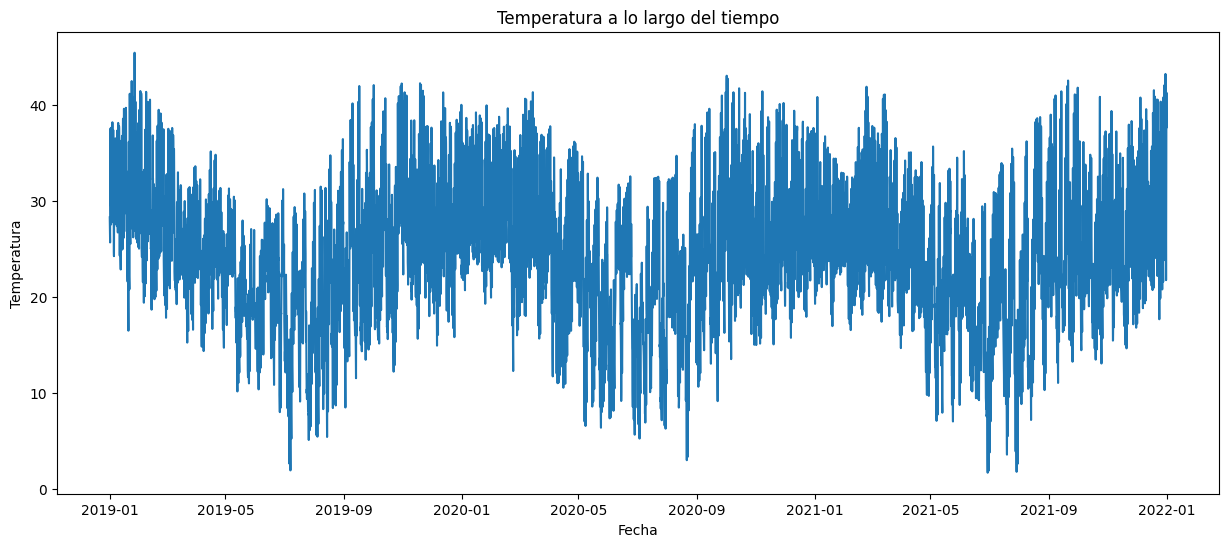

In [227]:
plt.figure(figsize=(15,6))
plt.plot(datos.index,datos['Temperatura'])
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Temperatura a lo largo del tiempo')
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


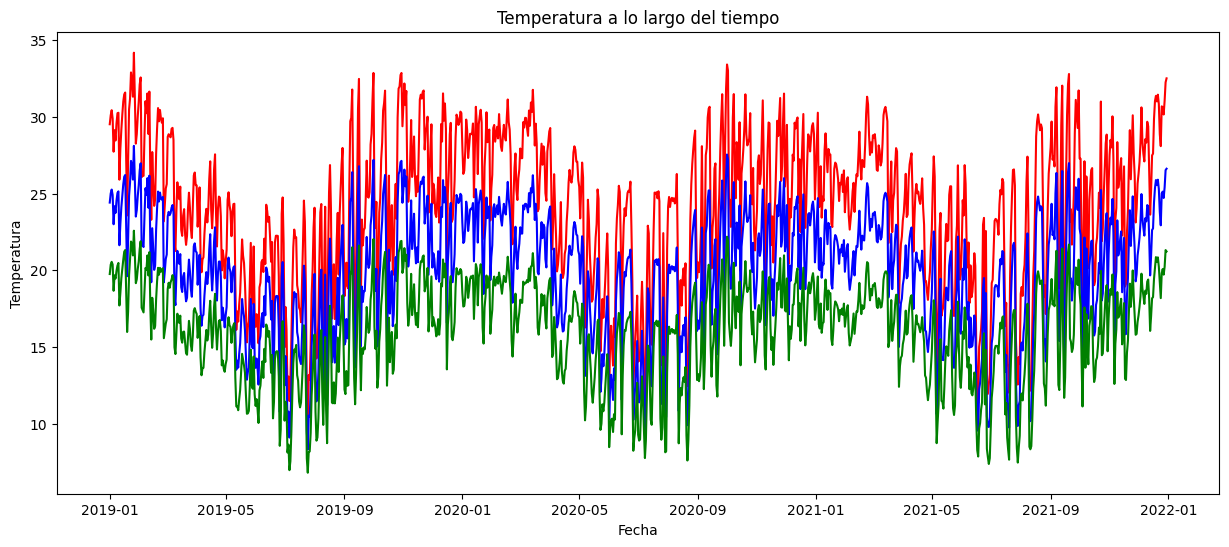

In [226]:
plt.figure(figsize=(15,6))
plt.plot(percentiles_diarios.index,modelo_final.predict(X)[:,0]/10,color='red')
plt.plot(percentiles_diarios.index,modelo_final.predict(X)[:,1]/10,color='blue')
plt.plot(percentiles_diarios.index,modelo_final.predict(X)[:,2]/10,color='green')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Temperatura a lo largo del tiempo')
plt.show()

In [220]:
modelo_final.predict(X)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[295.1397 , 244.1106 , 197.56564],
       [300.964  , 250.05911, 203.68092],
       [304.28784, 252.59882, 205.51305],
       ...,
       [310.45178, 254.02136, 202.2764 ],
       [322.46384, 265.26215, 213.17638],
       [325.0357 , 266.1664 , 212.27806]], dtype=float32)